# EuroSAT Dataset Applying Pre-trained CNN EfficientNetV2 (s)

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


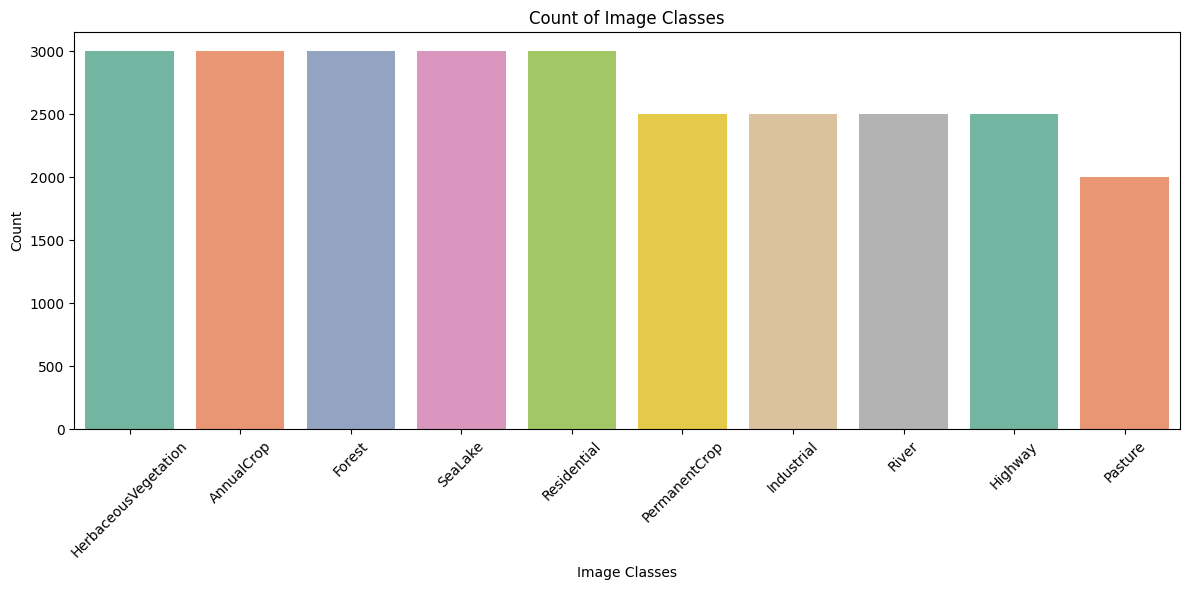

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

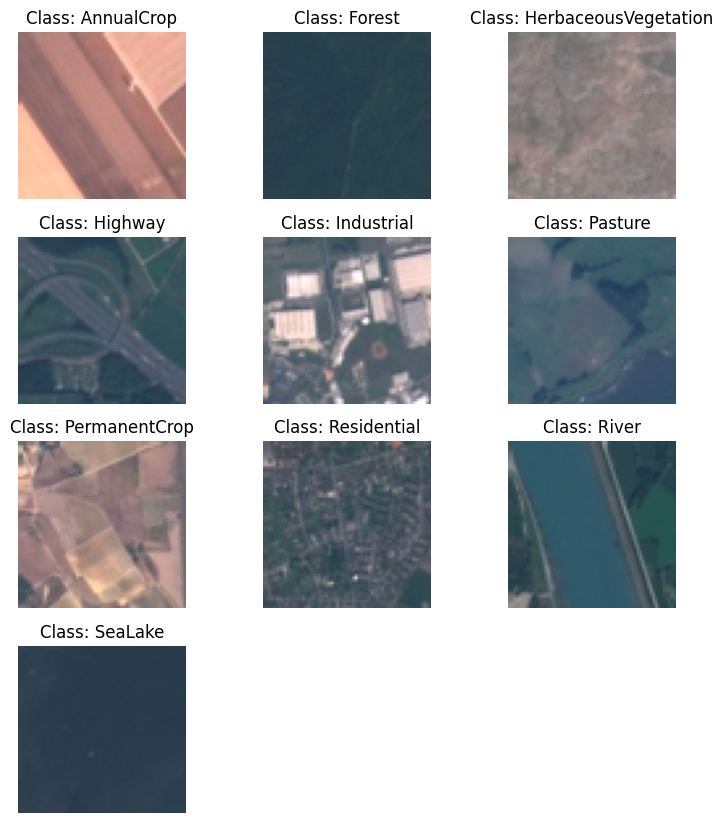

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

Label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [15]:
train_batch = 64 
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
    ])
    
    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (EfficientNet-v2-s)

In [16]:
total_class = 10
learning_rate = 0.0001

model = models.efficientnet_v2_s(pretrained=False)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
summary(model, input_size=(3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

### Training

In [17]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 296/296 [02:07<00:00,  2.32it/s, acc=0.423, loss=1.58]

Training Loss: 1.579 Acc: 0.423


Validation Loss: 0.944 Acc: 0.649
✅ Best model saved at epoch 1 with validation accuracy: 0.649


Epoch 2/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.648, loss=1]   

Training Loss: 1.001 Acc: 0.648


Validation Loss: 0.705 Acc: 0.758
✅ Best model saved at epoch 2 with validation accuracy: 0.758


Epoch 3/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.737, loss=0.763]

Training Loss: 0.763 Acc: 0.737


Validation Loss: 0.708 Acc: 0.774
✅ Best model saved at epoch 3 with validation accuracy: 0.774


Epoch 4/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.788, loss=0.631]

Training Loss: 0.631 Acc: 0.788


Validation Loss: 0.396 Acc: 0.870
✅ Best model saved at epoch 4 with validation accuracy: 0.870


Epoch 5/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.832, loss=0.513]

Training Loss: 0.513 Acc: 0.832


Validation Loss: 0.305 Acc: 0.898
✅ Best model saved at epoch 5 with validation accuracy: 0.898


Epoch 6/150: 100%|██████████| 296/296 [02:07<00:00,  2.33it/s, acc=0.852, loss=0.448]

Training Loss: 0.448 Acc: 0.852


Validation Loss: 0.254 Acc: 0.914
✅ Best model saved at epoch 6 with validation accuracy: 0.914


Epoch 7/150: 100%|██████████| 296/296 [02:07<00:00,  2.33it/s, acc=0.867, loss=0.393]

Training Loss: 0.393 Acc: 0.867


Validation Loss: 0.219 Acc: 0.929
✅ Best model saved at epoch 7 with validation accuracy: 0.929


Epoch 8/150: 100%|██████████| 296/296 [02:07<00:00,  2.33it/s, acc=0.883, loss=0.348]

Training Loss: 0.348 Acc: 0.883


Validation Loss: 0.215 Acc: 0.928


Epoch 9/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.892, loss=0.32] 

Training Loss: 0.320 Acc: 0.892


Validation Loss: 0.212 Acc: 0.926


Epoch 10/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.902, loss=0.292]

Training Loss: 0.292 Acc: 0.902


Validation Loss: 0.177 Acc: 0.938
✅ Best model saved at epoch 10 with validation accuracy: 0.938


Epoch 11/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.908, loss=0.276]

Training Loss: 0.276 Acc: 0.908


Validation Loss: 0.185 Acc: 0.937


Epoch 12/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.915, loss=0.252]

Training Loss: 0.252 Acc: 0.915


Validation Loss: 0.196 Acc: 0.932


Epoch 13/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.916, loss=0.245]

Training Loss: 0.245 Acc: 0.916


Validation Loss: 0.200 Acc: 0.931


Epoch 14/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.922, loss=0.235]

Training Loss: 0.235 Acc: 0.922


Validation Loss: 0.151 Acc: 0.947
✅ Best model saved at epoch 14 with validation accuracy: 0.947


Epoch 15/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.925, loss=0.222]

Training Loss: 0.222 Acc: 0.925


Validation Loss: 0.155 Acc: 0.946


Epoch 16/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.93, loss=0.208] 

Training Loss: 0.208 Acc: 0.930


Validation Loss: 0.162 Acc: 0.943


Epoch 17/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.931, loss=0.2]  

Training Loss: 0.200 Acc: 0.931


Validation Loss: 0.136 Acc: 0.953
✅ Best model saved at epoch 17 with validation accuracy: 0.953


Epoch 18/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.933, loss=0.2]  

Training Loss: 0.200 Acc: 0.933


Validation Loss: 0.157 Acc: 0.946


Epoch 19/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.935, loss=0.188]

Training Loss: 0.188 Acc: 0.935


Validation Loss: 0.119 Acc: 0.963
✅ Best model saved at epoch 19 with validation accuracy: 0.963


Epoch 20/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.937, loss=0.181]

Training Loss: 0.181 Acc: 0.937


Validation Loss: 0.123 Acc: 0.959


Epoch 21/150: 100%|██████████| 296/296 [02:07<00:00,  2.33it/s, acc=0.941, loss=0.171]

Training Loss: 0.171 Acc: 0.941


Validation Loss: 0.150 Acc: 0.949


Epoch 22/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.942, loss=0.171]

Training Loss: 0.171 Acc: 0.942


Validation Loss: 0.180 Acc: 0.933


Epoch 23/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.944, loss=0.164]

Training Loss: 0.164 Acc: 0.944


Validation Loss: 0.129 Acc: 0.958


Epoch 24/150: 100%|██████████| 296/296 [02:07<00:00,  2.32it/s, acc=0.946, loss=0.156]

Training Loss: 0.156 Acc: 0.946


Validation Loss: 0.121 Acc: 0.963
✅ Best model saved at epoch 24 with validation accuracy: 0.963


Epoch 25/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.946, loss=0.155]

Training Loss: 0.155 Acc: 0.946


Validation Loss: 0.107 Acc: 0.966
✅ Best model saved at epoch 25 with validation accuracy: 0.966


Epoch 26/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.947, loss=0.156]

Training Loss: 0.156 Acc: 0.947


Validation Loss: 0.114 Acc: 0.961


Epoch 27/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.948, loss=0.151]

Training Loss: 0.151 Acc: 0.948


Validation Loss: 0.111 Acc: 0.961


Epoch 28/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.951, loss=0.138]

Training Loss: 0.138 Acc: 0.951


Validation Loss: 0.116 Acc: 0.963


Epoch 29/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.951, loss=0.138]

Training Loss: 0.138 Acc: 0.951


Validation Loss: 0.114 Acc: 0.965


Epoch 30/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.954, loss=0.134]

Training Loss: 0.134 Acc: 0.954


Validation Loss: 0.145 Acc: 0.953


Epoch 31/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.954, loss=0.127]

Training Loss: 0.127 Acc: 0.954


Validation Loss: 0.107 Acc: 0.965


Epoch 32/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.953, loss=0.134]

Training Loss: 0.134 Acc: 0.953


Validation Loss: 0.117 Acc: 0.962


Epoch 33/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.957, loss=0.121]

Training Loss: 0.121 Acc: 0.957


Validation Loss: 0.102 Acc: 0.969
✅ Best model saved at epoch 33 with validation accuracy: 0.969


Epoch 34/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.957, loss=0.119]

Training Loss: 0.119 Acc: 0.957


Validation Loss: 0.102 Acc: 0.966


Epoch 35/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.959, loss=0.121]

Training Loss: 0.121 Acc: 0.959


Validation Loss: 0.097 Acc: 0.971
✅ Best model saved at epoch 35 with validation accuracy: 0.971


Epoch 36/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.96, loss=0.115] 

Training Loss: 0.115 Acc: 0.960


Validation Loss: 0.107 Acc: 0.967


Epoch 37/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.963, loss=0.108]

Training Loss: 0.108 Acc: 0.963


Validation Loss: 0.091 Acc: 0.973
✅ Best model saved at epoch 37 with validation accuracy: 0.973


Epoch 38/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.96, loss=0.117] 

Training Loss: 0.117 Acc: 0.960


Validation Loss: 0.128 Acc: 0.960


Epoch 39/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.963, loss=0.105]

Training Loss: 0.105 Acc: 0.963


Validation Loss: 0.102 Acc: 0.964


Epoch 40/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.963, loss=0.106] 

Training Loss: 0.106 Acc: 0.963


Validation Loss: 0.097 Acc: 0.969


Epoch 41/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.962, loss=0.107]

Training Loss: 0.107 Acc: 0.962


Validation Loss: 0.090 Acc: 0.972


Epoch 42/150: 100%|██████████| 296/296 [02:07<00:00,  2.33it/s, acc=0.961, loss=0.108]

Training Loss: 0.108 Acc: 0.961


Validation Loss: 0.090 Acc: 0.972


Epoch 43/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.964, loss=0.102] 

Training Loss: 0.102 Acc: 0.964


Validation Loss: 0.128 Acc: 0.960


Epoch 44/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.966, loss=0.0964]

Training Loss: 0.096 Acc: 0.966


Validation Loss: 0.085 Acc: 0.974
✅ Best model saved at epoch 44 with validation accuracy: 0.974


Epoch 45/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.965, loss=0.0984]

Training Loss: 0.098 Acc: 0.965


Validation Loss: 0.104 Acc: 0.966


Epoch 46/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.967, loss=0.0978]

Training Loss: 0.098 Acc: 0.967


Validation Loss: 0.110 Acc: 0.966


Epoch 47/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.967, loss=0.0917]

Training Loss: 0.092 Acc: 0.967


Validation Loss: 0.121 Acc: 0.961


Epoch 48/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.969, loss=0.0925]

Training Loss: 0.093 Acc: 0.969


Validation Loss: 0.086 Acc: 0.973


Epoch 49/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.97, loss=0.0846] 

Training Loss: 0.085 Acc: 0.970


Validation Loss: 0.091 Acc: 0.971


Epoch 50/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.967, loss=0.0914]

Training Loss: 0.091 Acc: 0.967


Validation Loss: 0.111 Acc: 0.969


Epoch 51/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.972, loss=0.0804]

Training Loss: 0.080 Acc: 0.972


Validation Loss: 0.106 Acc: 0.969


Epoch 52/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.97, loss=0.0885] 

Training Loss: 0.089 Acc: 0.970


Validation Loss: 0.096 Acc: 0.971


Epoch 53/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.972, loss=0.0806]

Training Loss: 0.081 Acc: 0.972


Validation Loss: 0.084 Acc: 0.978
✅ Best model saved at epoch 53 with validation accuracy: 0.978


Epoch 54/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.968, loss=0.0887]

Training Loss: 0.089 Acc: 0.968


Validation Loss: 0.105 Acc: 0.968


Epoch 55/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.972, loss=0.08]  

Training Loss: 0.080 Acc: 0.972


Validation Loss: 0.082 Acc: 0.975


Epoch 56/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.974, loss=0.0726]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.098 Acc: 0.973


Epoch 57/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.975, loss=0.0735]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.090 Acc: 0.976


Epoch 58/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.975, loss=0.0749]

Training Loss: 0.075 Acc: 0.975


Validation Loss: 0.085 Acc: 0.976


Epoch 59/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.971, loss=0.0792]

Training Loss: 0.079 Acc: 0.971


Validation Loss: 0.089 Acc: 0.976


Epoch 60/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.977, loss=0.0693]

Training Loss: 0.069 Acc: 0.977


Validation Loss: 0.087 Acc: 0.973


Epoch 61/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.974, loss=0.0748]

Training Loss: 0.075 Acc: 0.974


Validation Loss: 0.080 Acc: 0.977


Epoch 62/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.977, loss=0.0707]

Training Loss: 0.071 Acc: 0.977


Validation Loss: 0.096 Acc: 0.970


Epoch 63/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.974, loss=0.0743]

Training Loss: 0.074 Acc: 0.974


Validation Loss: 0.085 Acc: 0.976


Epoch 64/150: 100%|██████████| 296/296 [02:06<00:00,  2.33it/s, acc=0.977, loss=0.0679]

Training Loss: 0.068 Acc: 0.977


Validation Loss: 0.087 Acc: 0.978
✅ Best model saved at epoch 64 with validation accuracy: 0.978


Epoch 65/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.979, loss=0.0618]

Training Loss: 0.062 Acc: 0.979


Validation Loss: 0.090 Acc: 0.975


Epoch 66/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.977, loss=0.0667]

Training Loss: 0.067 Acc: 0.977


Validation Loss: 0.093 Acc: 0.971


Epoch 67/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.979, loss=0.0613]

Training Loss: 0.061 Acc: 0.979


Validation Loss: 0.092 Acc: 0.977


Epoch 68/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.977, loss=0.0633]

Training Loss: 0.063 Acc: 0.977


Validation Loss: 0.077 Acc: 0.978


Epoch 69/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.978, loss=0.0627]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.079 Acc: 0.977


Epoch 70/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.978, loss=0.0622]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.089 Acc: 0.976


Epoch 71/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.979, loss=0.0594]

Training Loss: 0.059 Acc: 0.979


Validation Loss: 0.080 Acc: 0.977


Epoch 72/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.977, loss=0.0651]

Training Loss: 0.065 Acc: 0.977


Validation Loss: 0.092 Acc: 0.975


Epoch 73/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.981, loss=0.0536]

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.087 Acc: 0.978


Epoch 74/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.979, loss=0.0601]

Training Loss: 0.060 Acc: 0.979


Validation Loss: 0.093 Acc: 0.973


Epoch 75/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.978, loss=0.0623]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.087 Acc: 0.975


Epoch 76/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.981, loss=0.0556]

Training Loss: 0.056 Acc: 0.981


Validation Loss: 0.083 Acc: 0.977


Epoch 77/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.982, loss=0.0543]

Training Loss: 0.054 Acc: 0.982


Validation Loss: 0.073 Acc: 0.979
✅ Best model saved at epoch 77 with validation accuracy: 0.979


Epoch 78/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.98, loss=0.0564] 

Training Loss: 0.056 Acc: 0.980


Validation Loss: 0.101 Acc: 0.974


Epoch 79/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.979, loss=0.0591]

Training Loss: 0.059 Acc: 0.979


Validation Loss: 0.091 Acc: 0.973


Epoch 80/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.983, loss=0.0498]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.075 Acc: 0.978


Epoch 81/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.981, loss=0.054] 

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.095 Acc: 0.975


Epoch 82/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.983, loss=0.0482]

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.090 Acc: 0.976


Epoch 83/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.983, loss=0.051] 

Training Loss: 0.051 Acc: 0.983


Validation Loss: 0.071 Acc: 0.978


Epoch 84/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.984, loss=0.0479]

Training Loss: 0.048 Acc: 0.984


Validation Loss: 0.089 Acc: 0.978


Epoch 85/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.982, loss=0.052] 

Training Loss: 0.052 Acc: 0.982


Validation Loss: 0.111 Acc: 0.970


Epoch 86/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.983, loss=0.0481]

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.085 Acc: 0.976


Epoch 87/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.983, loss=0.0513]

Training Loss: 0.051 Acc: 0.983


Validation Loss: 0.080 Acc: 0.977


Epoch 88/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.985, loss=0.0421]

Training Loss: 0.042 Acc: 0.985


Validation Loss: 0.093 Acc: 0.978


Epoch 89/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.983, loss=0.0486]

Training Loss: 0.049 Acc: 0.983


Validation Loss: 0.092 Acc: 0.974


Epoch 90/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.985, loss=0.0456]


Training Loss: 0.046 Acc: 0.985
Validation Loss: 0.079 Acc: 0.978


Epoch 91/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.984, loss=0.0482]

Training Loss: 0.048 Acc: 0.984


Validation Loss: 0.101 Acc: 0.977


Epoch 92/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.984, loss=0.0465]

Training Loss: 0.046 Acc: 0.984


Validation Loss: 0.104 Acc: 0.971


Epoch 93/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.984, loss=0.0472]

Training Loss: 0.047 Acc: 0.984


Validation Loss: 0.090 Acc: 0.976


Epoch 94/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.985, loss=0.0419]

Training Loss: 0.042 Acc: 0.985


Validation Loss: 0.092 Acc: 0.976


Epoch 95/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.985, loss=0.0418]

Training Loss: 0.042 Acc: 0.985


Validation Loss: 0.081 Acc: 0.979
✅ Best model saved at epoch 95 with validation accuracy: 0.979


Epoch 96/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.984, loss=0.0432]

Training Loss: 0.043 Acc: 0.984


Validation Loss: 0.080 Acc: 0.980
✅ Best model saved at epoch 96 with validation accuracy: 0.980


Epoch 97/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.986, loss=0.0407]

Training Loss: 0.041 Acc: 0.986


Validation Loss: 0.102 Acc: 0.973


Epoch 98/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.986, loss=0.0394]

Training Loss: 0.039 Acc: 0.986


Validation Loss: 0.109 Acc: 0.976


Epoch 99/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.985, loss=0.0446]

Training Loss: 0.045 Acc: 0.985


Validation Loss: 0.076 Acc: 0.981
✅ Best model saved at epoch 99 with validation accuracy: 0.981


Epoch 100/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.987, loss=0.0384]

Training Loss: 0.038 Acc: 0.987


Validation Loss: 0.113 Acc: 0.970


Epoch 101/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.987, loss=0.041] 

Training Loss: 0.041 Acc: 0.987


Validation Loss: 0.087 Acc: 0.974


Epoch 102/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.987, loss=0.0379]

Training Loss: 0.038 Acc: 0.987


Validation Loss: 0.074 Acc: 0.979


Epoch 103/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.986, loss=0.0387]

Training Loss: 0.039 Acc: 0.986


Validation Loss: 0.084 Acc: 0.978


Epoch 104/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.987, loss=0.0365]

Training Loss: 0.037 Acc: 0.987


Validation Loss: 0.081 Acc: 0.978


Epoch 105/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.986, loss=0.041] 

Training Loss: 0.041 Acc: 0.986


Validation Loss: 0.082 Acc: 0.979


Epoch 106/150: 100%|██████████| 296/296 [02:06<00:00,  2.35it/s, acc=0.987, loss=0.0385]

Training Loss: 0.038 Acc: 0.987


Validation Loss: 0.105 Acc: 0.972


Epoch 107/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.988, loss=0.0339]

Training Loss: 0.034 Acc: 0.988


Validation Loss: 0.085 Acc: 0.982
✅ Best model saved at epoch 107 with validation accuracy: 0.982


Epoch 108/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.987, loss=0.0379]

Training Loss: 0.038 Acc: 0.987


Validation Loss: 0.097 Acc: 0.978


Epoch 109/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.989, loss=0.0332]

Training Loss: 0.033 Acc: 0.989


Validation Loss: 0.090 Acc: 0.978


Epoch 110/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.987, loss=0.0356]

Training Loss: 0.036 Acc: 0.987


Validation Loss: 0.081 Acc: 0.978


Epoch 111/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.988, loss=0.0371]

Training Loss: 0.037 Acc: 0.988


Validation Loss: 0.096 Acc: 0.977


Epoch 112/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.988, loss=0.038] 

Training Loss: 0.038 Acc: 0.988


Validation Loss: 0.100 Acc: 0.980


Epoch 113/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.989, loss=0.0359]

Training Loss: 0.036 Acc: 0.989


Validation Loss: 0.087 Acc: 0.977


Epoch 114/150: 100%|██████████| 296/296 [02:06<00:00,  2.34it/s, acc=0.99, loss=0.0292] 

Training Loss: 0.029 Acc: 0.990


Validation Loss: 0.082 Acc: 0.976


Epoch 115/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.988, loss=0.0341]

Training Loss: 0.034 Acc: 0.988


Validation Loss: 0.098 Acc: 0.980


Epoch 116/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.99, loss=0.0277] 

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.098 Acc: 0.979


Epoch 117/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.987, loss=0.0387]

Training Loss: 0.039 Acc: 0.987


Validation Loss: 0.091 Acc: 0.980


Epoch 118/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.986, loss=0.0372]

Training Loss: 0.037 Acc: 0.986


Validation Loss: 0.089 Acc: 0.978


Epoch 119/150: 100%|██████████| 296/296 [02:05<00:00,  2.35it/s, acc=0.99, loss=0.0303] 

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.094 Acc: 0.978


Epoch 120/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.987, loss=0.0369]

Training Loss: 0.037 Acc: 0.987


Validation Loss: 0.080 Acc: 0.981


Epoch 121/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.0299]

Training Loss: 0.030 Acc: 0.989


Validation Loss: 0.085 Acc: 0.980


Epoch 122/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.0312]

Training Loss: 0.031 Acc: 0.989


Validation Loss: 0.081 Acc: 0.982


Epoch 123/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.0286]

Training Loss: 0.029 Acc: 0.989


Validation Loss: 0.082 Acc: 0.979


Epoch 124/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.0322]


Training Loss: 0.032 Acc: 0.989
Validation Loss: 0.122 Acc: 0.973


Epoch 125/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.0273]


Training Loss: 0.027 Acc: 0.991
Validation Loss: 0.088 Acc: 0.980


Epoch 126/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.0316]


Training Loss: 0.032 Acc: 0.989
Validation Loss: 0.079 Acc: 0.979


Epoch 127/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.0318]

Training Loss: 0.032 Acc: 0.989


Validation Loss: 0.096 Acc: 0.978


Epoch 128/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.992, loss=0.0258]

Training Loss: 0.026 Acc: 0.992


Validation Loss: 0.091 Acc: 0.979


Epoch 129/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.99, loss=0.0312] 


Training Loss: 0.031 Acc: 0.990
Validation Loss: 0.091 Acc: 0.975


Epoch 130/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.99, loss=0.0292] 


Training Loss: 0.029 Acc: 0.990
Validation Loss: 0.085 Acc: 0.981


Epoch 131/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.0282]

Training Loss: 0.028 Acc: 0.991


Validation Loss: 0.126 Acc: 0.970


Epoch 132/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.034] 

Training Loss: 0.034 Acc: 0.989


Validation Loss: 0.086 Acc: 0.977


Epoch 133/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.99, loss=0.0282] 

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.093 Acc: 0.977


Epoch 134/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.99, loss=0.0262] 


Training Loss: 0.026 Acc: 0.990
Validation Loss: 0.086 Acc: 0.980


Epoch 135/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.0261]


Training Loss: 0.026 Acc: 0.991
Validation Loss: 0.092 Acc: 0.979


Epoch 136/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.989, loss=0.03]  

Training Loss: 0.030 Acc: 0.989


Validation Loss: 0.091 Acc: 0.979


Epoch 137/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.992, loss=0.0245]

Training Loss: 0.025 Acc: 0.992


Validation Loss: 0.089 Acc: 0.979


Epoch 138/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.0227]

Training Loss: 0.023 Acc: 0.991


Validation Loss: 0.095 Acc: 0.979


Epoch 139/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.0279]

Training Loss: 0.028 Acc: 0.991


Validation Loss: 0.087 Acc: 0.979


Epoch 140/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.0275]


Training Loss: 0.027 Acc: 0.991
Validation Loss: 0.111 Acc: 0.978


Epoch 141/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.99, loss=0.0287] 


Training Loss: 0.029 Acc: 0.990
Validation Loss: 0.085 Acc: 0.979


Epoch 142/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.992, loss=0.0243]


Training Loss: 0.024 Acc: 0.992
Validation Loss: 0.094 Acc: 0.979


Epoch 143/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.99, loss=0.0288] 


Training Loss: 0.029 Acc: 0.990
Validation Loss: 0.097 Acc: 0.975


Epoch 144/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.0288]

Training Loss: 0.029 Acc: 0.991


Validation Loss: 0.088 Acc: 0.979


Epoch 145/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.992, loss=0.0255]

Training Loss: 0.026 Acc: 0.992


Validation Loss: 0.087 Acc: 0.979


Epoch 146/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.993, loss=0.0199]

Training Loss: 0.020 Acc: 0.993


Validation Loss: 0.099 Acc: 0.978


Epoch 147/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.991, loss=0.027] 


Training Loss: 0.027 Acc: 0.991
Validation Loss: 0.087 Acc: 0.982
✅ Best model saved at epoch 147 with validation accuracy: 0.982


Epoch 148/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.992, loss=0.022] 


Training Loss: 0.022 Acc: 0.992
Validation Loss: 0.094 Acc: 0.980


Epoch 149/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.992, loss=0.0239]

Training Loss: 0.024 Acc: 0.992


Validation Loss: 0.119 Acc: 0.974


Epoch 150/150: 100%|██████████| 296/296 [02:05<00:00,  2.36it/s, acc=0.992, loss=0.0222]

Training Loss: 0.022 Acc: 0.992


Validation Loss: 0.100 Acc: 0.980
Training Time: 21126.86 seconds ---> 352.11 minutes


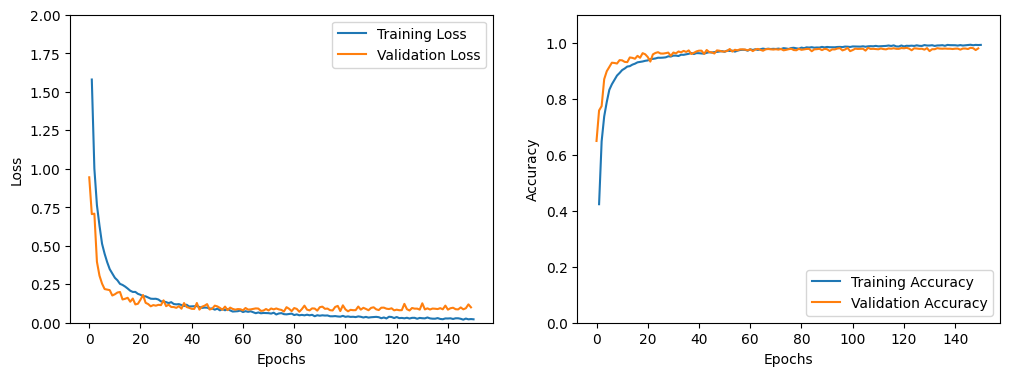

In [24]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [25]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 147) - Validation Loss: 0.091, Validation Accuracy: 0.983


In [26]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.981
Test Time: 12.57 seconds ---> 0.21 minutes


### Class Accuracy

In [27]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       450
           1       0.99      1.00      0.99       450
           2       0.96      0.97      0.96       450
           3       0.98      0.98      0.98       375
           4       0.99      0.99      0.99       375
           5       0.97      0.97      0.97       300
           6       0.96      0.95      0.95       375
           7       1.00      0.98      0.99       450
           8       0.98      0.98      0.98       375
           9       0.99      1.00      0.99       450

    accuracy                           0.98      4050
   macro avg       0.98      0.98      0.98      4050
weighted avg       0.98      0.98      0.98      4050

Class 0 Accuracy: 0.964
Class 1 Accuracy: 1.000
Class 2 Accuracy: 0.976
Class 3 Accuracy: 0.987
Class 4 Accuracy: 0.987
Class 5 Accuracy: 0.970
Class 6 Accuracy: 0.955
Class 7 Accuracy: 0.987
Class 8 Accuracy: 0.981
Cl

### Confusion Matrix

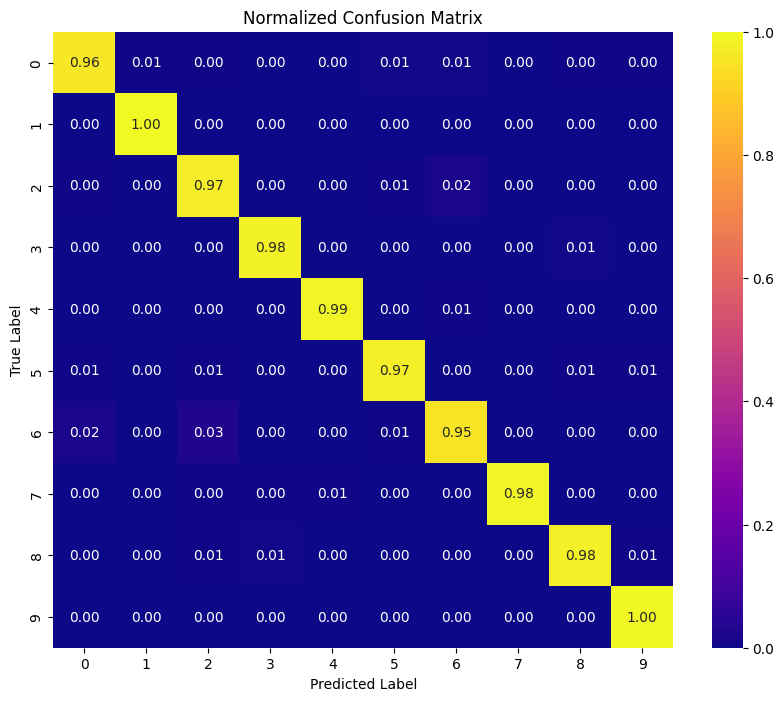

In [28]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC ROC Curve

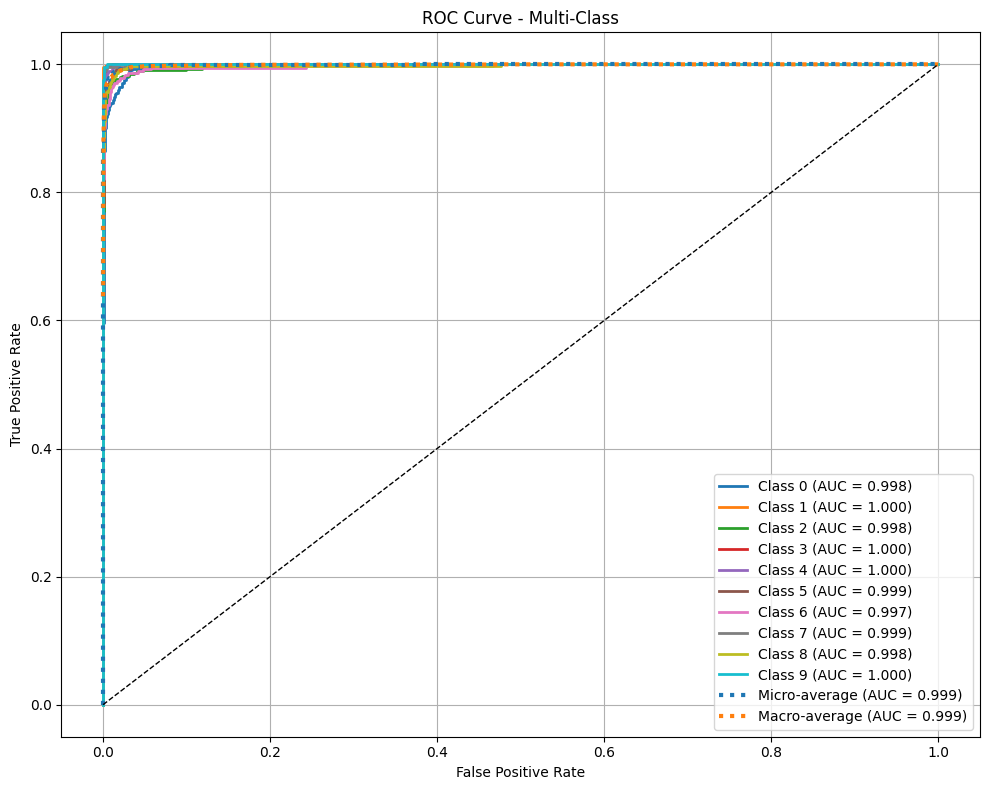

In [29]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()